# GMRA consistency roundup

## Grab data

The setup: first we embed BBC news articles with roberta.  

Then we'll train the GMRA with the same settings we've been using:
- min leaf size = 10
- base = 1.35
- d = 25  

We'll use 'tech' as the testing data, and the rest as the training data, just like we've been doing.  
We've been using KNN as the outlier detection technique, so we'll plot those, as well as potentially GMM.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload
from tqdm.notebook import tqdm
import warnings; warnings.filterwarnings("ignore")
import time
import numpy as np
import pandas as pd
import polars as pl
from pyod.models.gmm import GMM
from pyod.models.kde import KDE
from pyod.models.knn import KNN

from gmradriver.utils import GMRA
from gmradriver.plot.plotters import _get_nodes, _get_idx, _get_basis
from data import kwargs, bbc_train, bbc_test, bbc_y_train, bbc_y_test
from data import doc2vec_bbc, minilm_bbc, mpnet_bbc, roberta_bbc, word2vec_bbc
from data import new_embeddings
gmra_kwargs = kwargs
del kwargs
import seaborn as sns
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

def _project_points(data, node, on_train=True, scaling_basis=True, y_train_test=None):
    """
    returns indices and projected data

    y_train_test is either the labels for the training data or the testing data
    """
    if not scaling_basis:
        raise NotImplementedError
    idx = _get_idx(node, on_train=on_train)
    # basis = _get_basis(node, on_scaling=scaling_basis)
    # data = data[idx, :]
    # if basis.shape == (0, 0):
    #     warnings.warn(f"No basis found for node {node.name()}. Adding nan values.")
    #     return idx, np.full((data.shape[0], 2), np.nan)
    # projected = data @ basis
    # StandardScaler(with_std=False).fit_transform(projected)
    projected = node.train_scaling_coeffs().T if on_train else node.test_scaling_coeffs().T
    if y_train_test is not None:
        idx = _get_idx(node, on_train=on_train)
        y = y_train_test[idx]
        assert len(y) == len(projected)
        return projected, y
    return projected

import matplotlib.pyplot as plt

data, name = roberta_bbc, "roberta"
df_KNN = pd.read_csv(f"df_KNN_{name}.csv", index_col=False).drop('Unnamed: 0', axis=1)

# load the data
labels_new = pd.read_csv("/home/aloftus/data/bbc/new_labels.csv", header=None).values.ravel()
train_val = 'tech'
idxer = labels_new==train_val
data = pd.DataFrame(data)
data.insert(0, "ArticleId", np.arange(len(labels_new)))
X_train, Y_train, X_test, Y_test = data[~idxer].reset_index(drop=True), labels_new[~idxer], data[idxer].reset_index(drop=True), labels_new[idxer]
dimensions = np.unique(np.linspace(0, X_train.shape[1], num=15).astype(int))
dimensions[0] = 2
kind = 'KNN'
gmra_kwargs['num_threads'] = -1
gmra_kwargs['d'] = 25
gmra_kwargs['on_train_wav'] = False
gmra_kwargs['compute_cov'] = False
gmra_kwargs['non_isotropic'] = False

## Plot projection of the data from ambient space to 2d with UMAP

So, this plot is exactly what it looks like. We take all the data from ambient space, and project it into 2 dimensions with a UMAP. This is what it looks like as a baseline.

In [2]:
from umap import UMAP

# turn into a Polars dataframe
df = pd.concat((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
df.insert(loc=1, column='labels', value=Y)
df = pl.DataFrame(df)
df.head()

# project with UMAP and plot
data_df = df.select(pl.exclude(["ArticleId", "labels"]))
projected = UMAP(n_components=2).fit_transform(data_df.to_pandas())
data_df_proj = pl.DataFrame({'x': projected[:, 0], 'y': projected[:, 1], 'labels': df['labels']})
data_df_proj = data_df_proj.with_columns(
    data_df_proj['labels']
    .apply(lambda x: 'test' if x=='tech' else 'train')
    .alias('on')
)

2023-02-03 17:09:03.374264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-03 17:09:03.522456: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-03 17:09:04.290255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-03 17:09:04.290348: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

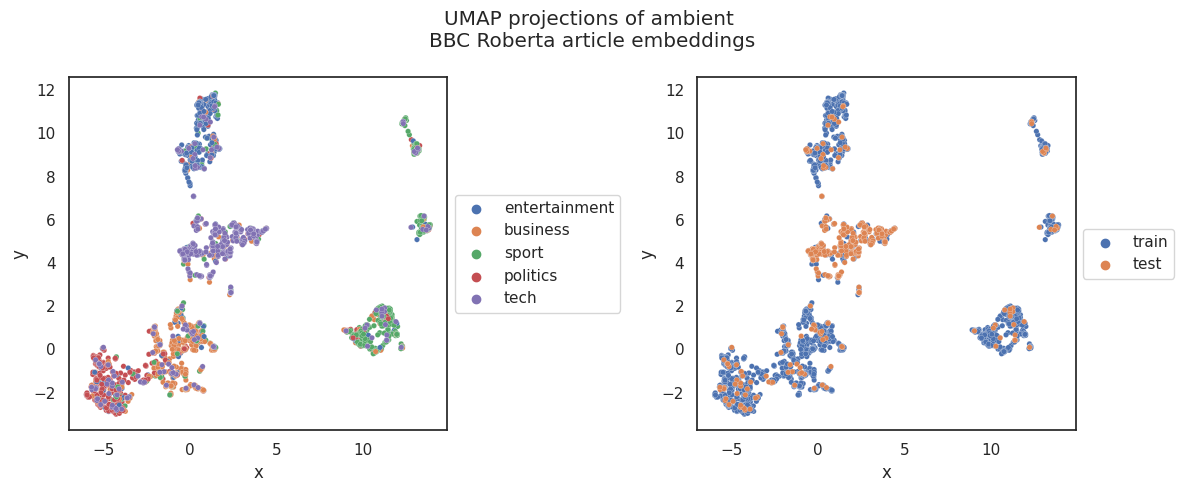

In [3]:
import seaborn as sns
import seaborn.objects as so

# import seaborn as sns
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# g = so.Plot(data_df_proj.to_pandas(), x="x", y="y").layout(size=(5, 5)).add(so.Dot(pointsize=3))
sns.scatterplot(data_df_proj.to_pandas(), x='x', y='y', hue="labels", s=15, linewidth=.15, ax=axs[0])
leg = axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')

sns.scatterplot(data_df_proj.to_pandas(), x='x', y='y', hue="on", s=15, linewidth=.15, ax=axs[1])

leg = plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
plt.suptitle("UMAP projections of ambient \nBBC Roberta article embeddings")
plt.tight_layout()

## Train a GMRA in 20 dimensions

Now, we're going to try training a GMRA into 20 dimensions, then exploring the tree. We'll find a set of branches that the testing data seems to have flowed into, and then plot the umap projections of each of the nodes in those branches. Then we'll calculate metrics like distance-from-mean and so forth, comparing directly as we descend a branch.

In [6]:
%autoreload
from gmradriver import GMRA

def train_gmra(d, x_train, x_test, gmra_kwargs):
    x_train = x_train.drop("ArticleId", axis='columns').values.copy()
    x_test = x_test.drop("ArticleId", axis='columns').values.copy()
    gmra_kwargs['d'] = d
    gmra = GMRA(**gmra_kwargs)

    gmra.fit(x_train)
    tree = gmra.transform(x_test)
    print(tree[0].keys())
    root = tree[0][1][0]
    print(f"gmra with d={d} saved")

    # return root
    return gmra, tree, root

d = 20
gmra_kwargs['num_threads'] = 1  # -1 doesn't work, and as far as I can tell num_threads doesnt change alg speed
gmra_kwargs['reindex_tree_nodes'] = False
gmra, tree, root = train_gmra(d=d, x_train=X_train, x_test=X_test, gmra_kwargs=gmra_kwargs)

dict_keys([2, 1, 0, -1, -2147483648])
gmra with d=20 saved


## Plot tree

The plots here (at least in the training tree) are colored by entropy. Remember that entropy measures the amount of class heterogeneity in a node. We'll then pick a branch to move down.

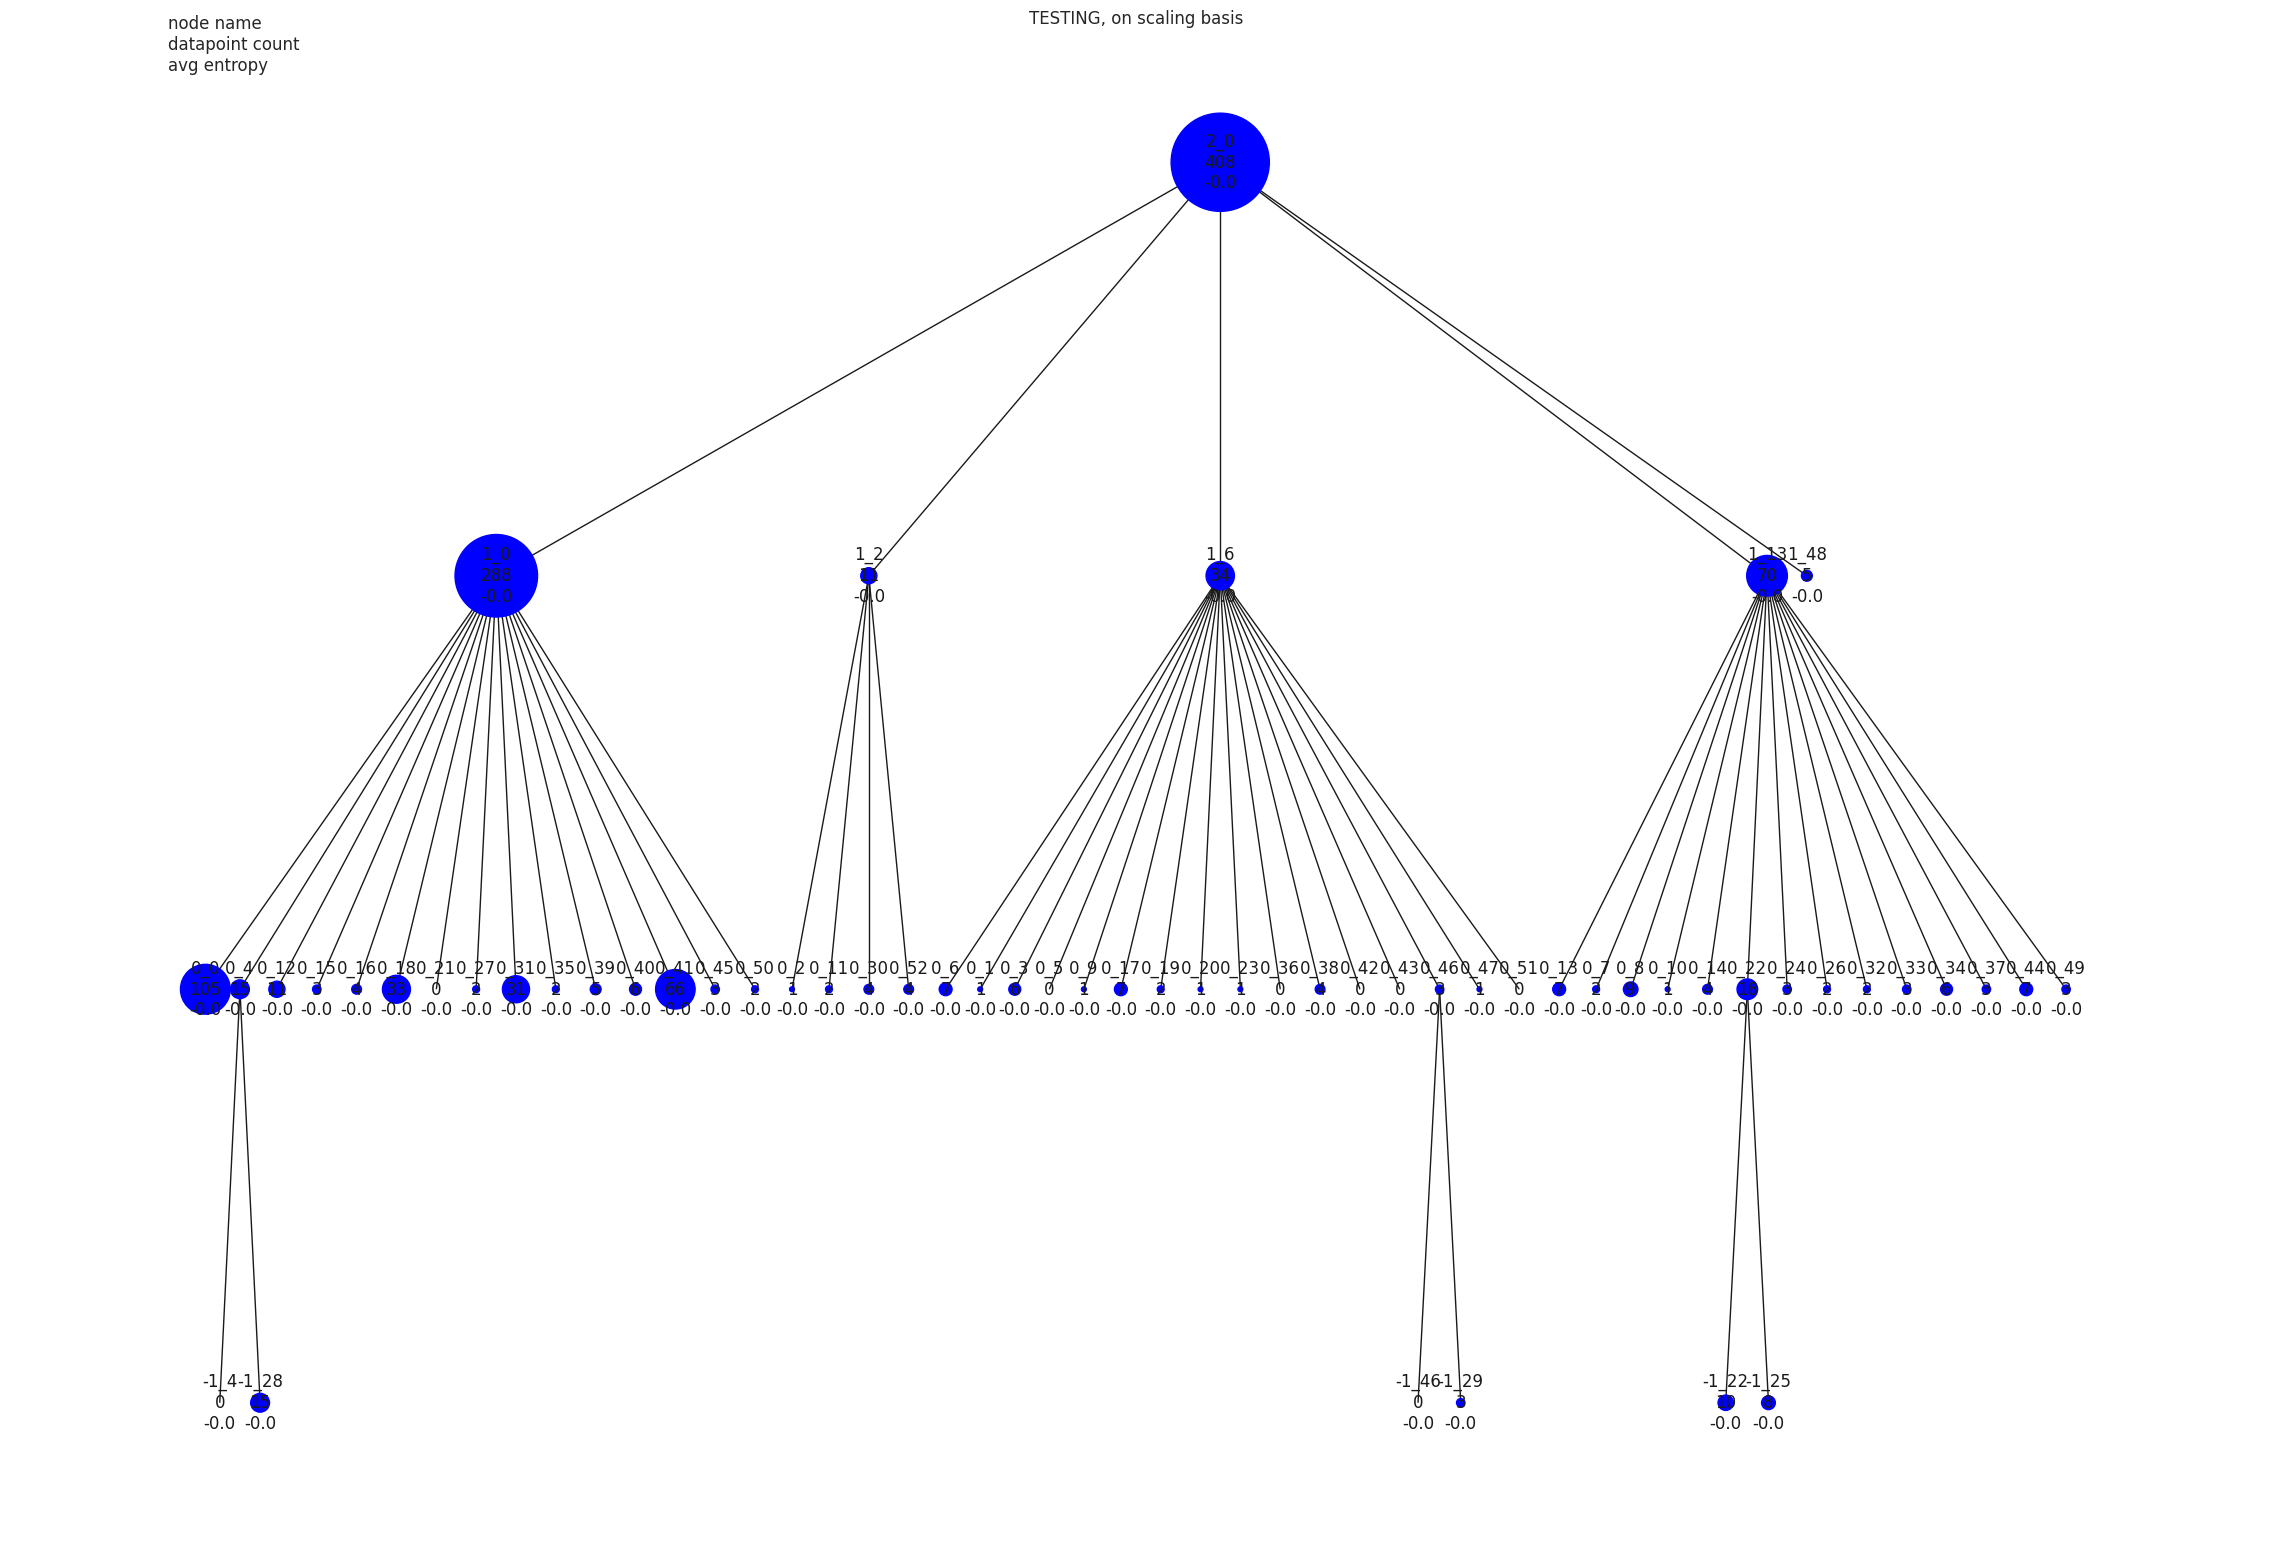

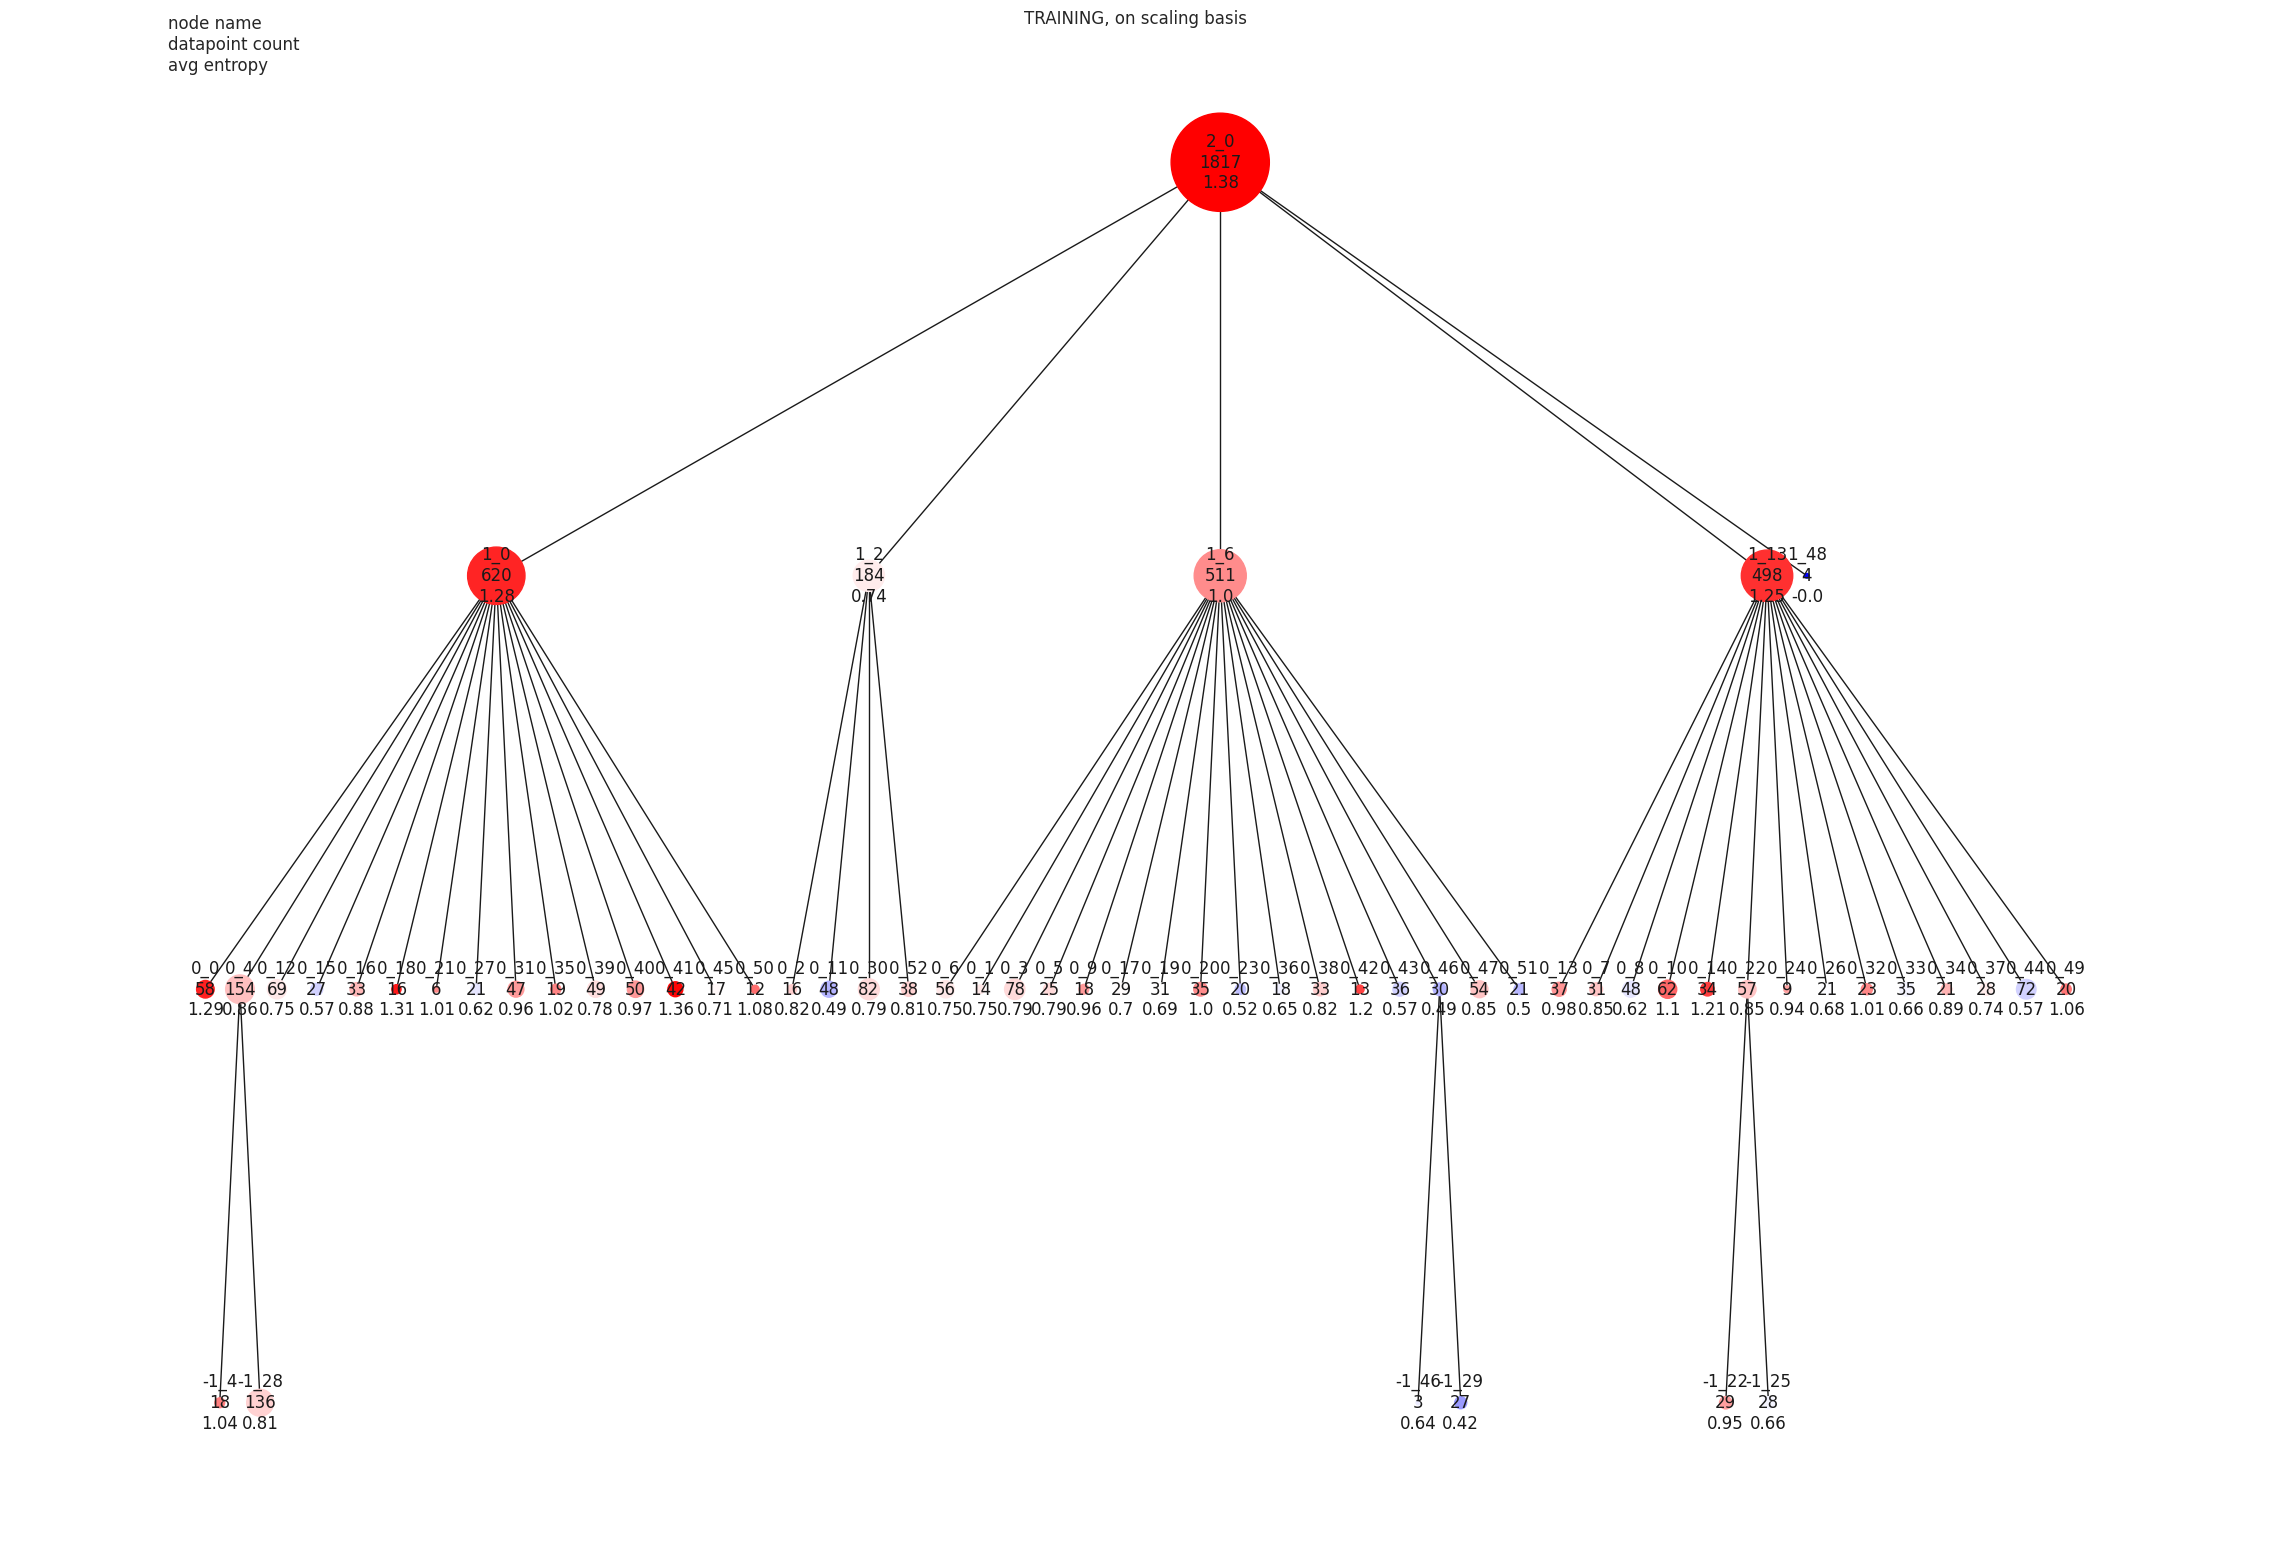

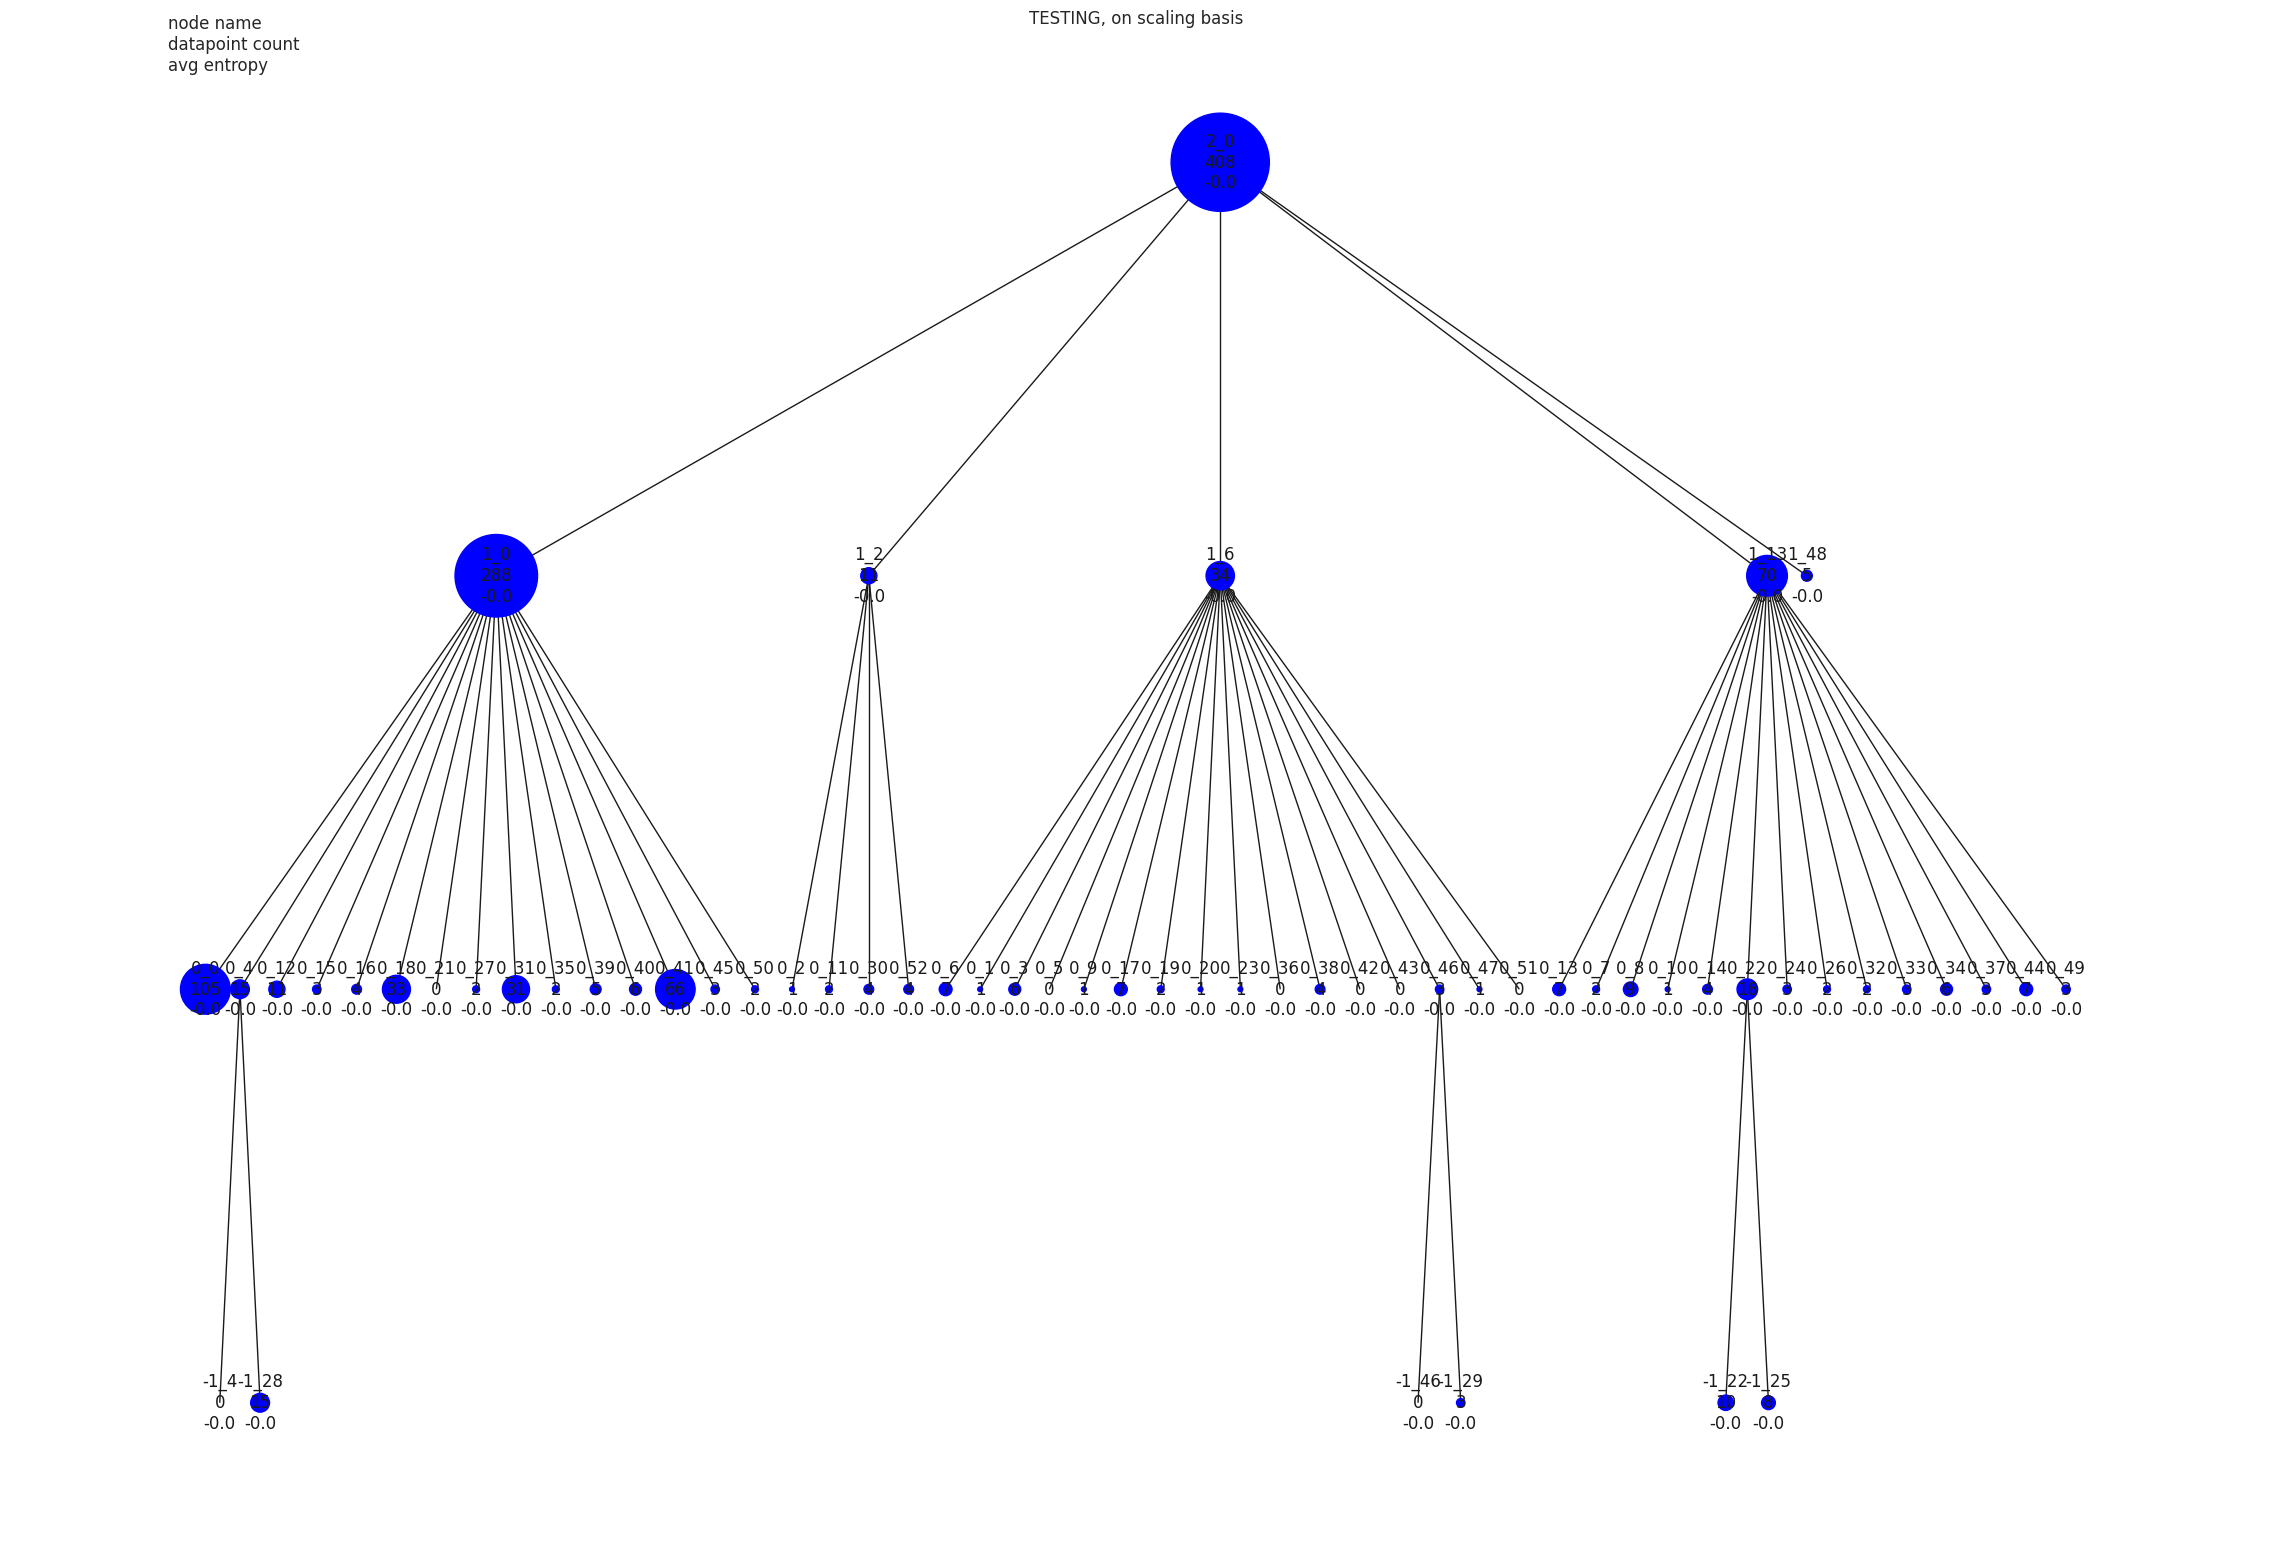

In [7]:
from gmradriver import Plotter
x_train = X_train.drop("ArticleId", axis='columns').values.copy()
x_test = X_test.drop("ArticleId", axis='columns').values.copy()


p = Plotter(tree[0], x_train=x_train, x_test=x_test, y_train=Y_train, y_test=Y_test)
p.plot_tree(hue='entropy')

### Pick branch of the tree

The obvious branch to pick is root > 1_0 > 0_0, since a majority of the testing data goes there. There are other interesting branches, but in pursuit of brevity and time-management, we'll pick this set.

In [13]:
branch = ['2_0', '1_0', '0_0']

#### Note

The plots (at least the ones colored by labels rather than train/test) don't have corresponding labels. I could have made the labels correspond color-wise, but as i've discovered in the past it's surprisingly annoying to do that and would involve collecting everything into a big dataframe and then plotting like that (one of the reasons I've used dataframes as my primary data structure in the past). 

Again in the interest of brevity, and since I don't think it matters too much, we'll unfortunately keep the colors not-corresponding.

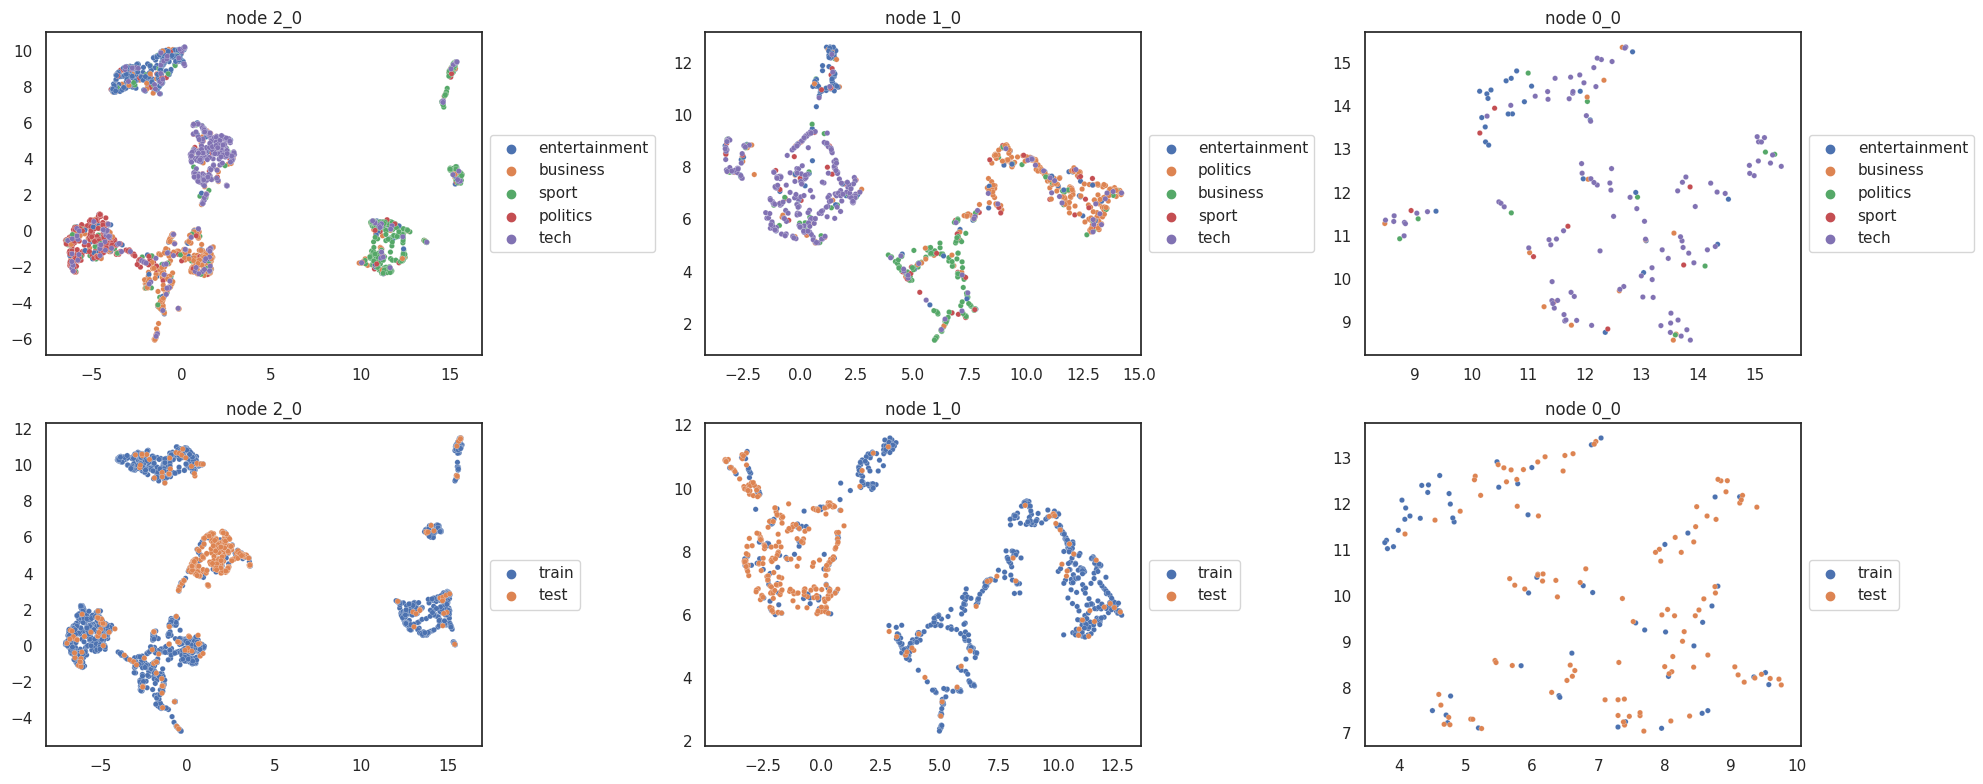

In [8]:
%autoreload

import seaborn as sns
from gmradriver.plot.plotters import _get_node

def _project_points(node, on_train=True, scaling_basis=True, y_train_test=None):
    """
    returns indices and projected data

    y_train_test is either the labels for the training data or the testing data
    """
    if not scaling_basis:
        raise NotImplementedError
    idx = _get_idx(node, on_train=on_train)
    projected = node.train_scaling_coeffs().T if on_train else node.test_scaling_coeffs().T
    if y_train_test is not None:
        idx = _get_idx(node, on_train=on_train)
        y = y_train_test[idx]
        assert len(y) == len(projected)
        return projected, y
    return projected

def project(node, y_train=None, y_test=None):

    # grab data
    train_data, y_train = _project_points(node, y_train_test=y_train)
    test_data, y_test = _project_points(node, on_train=False, y_train_test=y_test)

    # # concatenate
    node_data = np.concatenate((train_data, test_data))
    node_y = np.concatenate((y_train, y_test))

    # predict
    proj_data = UMAP(n_components=2).fit_transform(node_data)
    
    return proj_data, node_y

def plot(proj_data, node_y, ax=None):
    if ax is None:
        ax = plt.gca()
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                    hue=node_y, s=15, linewidth=.15, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
y_train = Y_train
y_test = Y_test
fix, axs = plt.subplots(2, 3, figsize=(20,8))
for node, ax in zip(['2_0', '1_0', '0_0'], axs[0, :].flatten()):
    node = _get_node(tree[0], node)
    proj_data, node_y = project(node, y_train=y_train, y_test=y_test)
    plot(proj_data, node_y, ax=ax)
    ax.set_title(f"node {node.name()}")
    
y_train = np.where(Y_train=='tech', 'test', 'train')
y_test = np.where(Y_test=='tech', 'test', 'train')
for node, ax in zip(branch, axs[1, :].flatten()):
    node = _get_node(tree[0], node)
    proj_data, node_y = project(node, y_train=y_train, y_test=y_test)
    plot(proj_data, node_y, ax=ax)
    ax.set_title(f"node {node.name()}")

plt.tight_layout()

On the top plots we see the data in each node (e.g., the scaling coefficients) projected down to 2 dimensions with UMAP and then colored by label. On the bottom plots we see the same data, but colored by train/test.

As we can see, the entertainment datapoints are largely near the tech data points in node 1_0. The data in node 0_0 has lost most of its structure; I think it's too sparse to be meaningful.

## Check distances and Outlier Scores

We'll check the distances from the mean, using method 2, from both the local mean and the ambient mean within each node. Remember that method 2 is the one where we center the training data on its mean, then center the testing data on the difference. We're this for local means, meaning the distance from the mean with respect to each node's subspace.

We'll plot the same UMAPs as above so that we can compare nodes along columns. 

The rows go:
- umap (from projected data, labels)
- umap (from projected data, train/test)
- histogram (distance from local mean)
- histogram (outlier detection score)

Discussion about this plot below.

#### first, get individual nodes

3it [00:15,  5.19s/it]


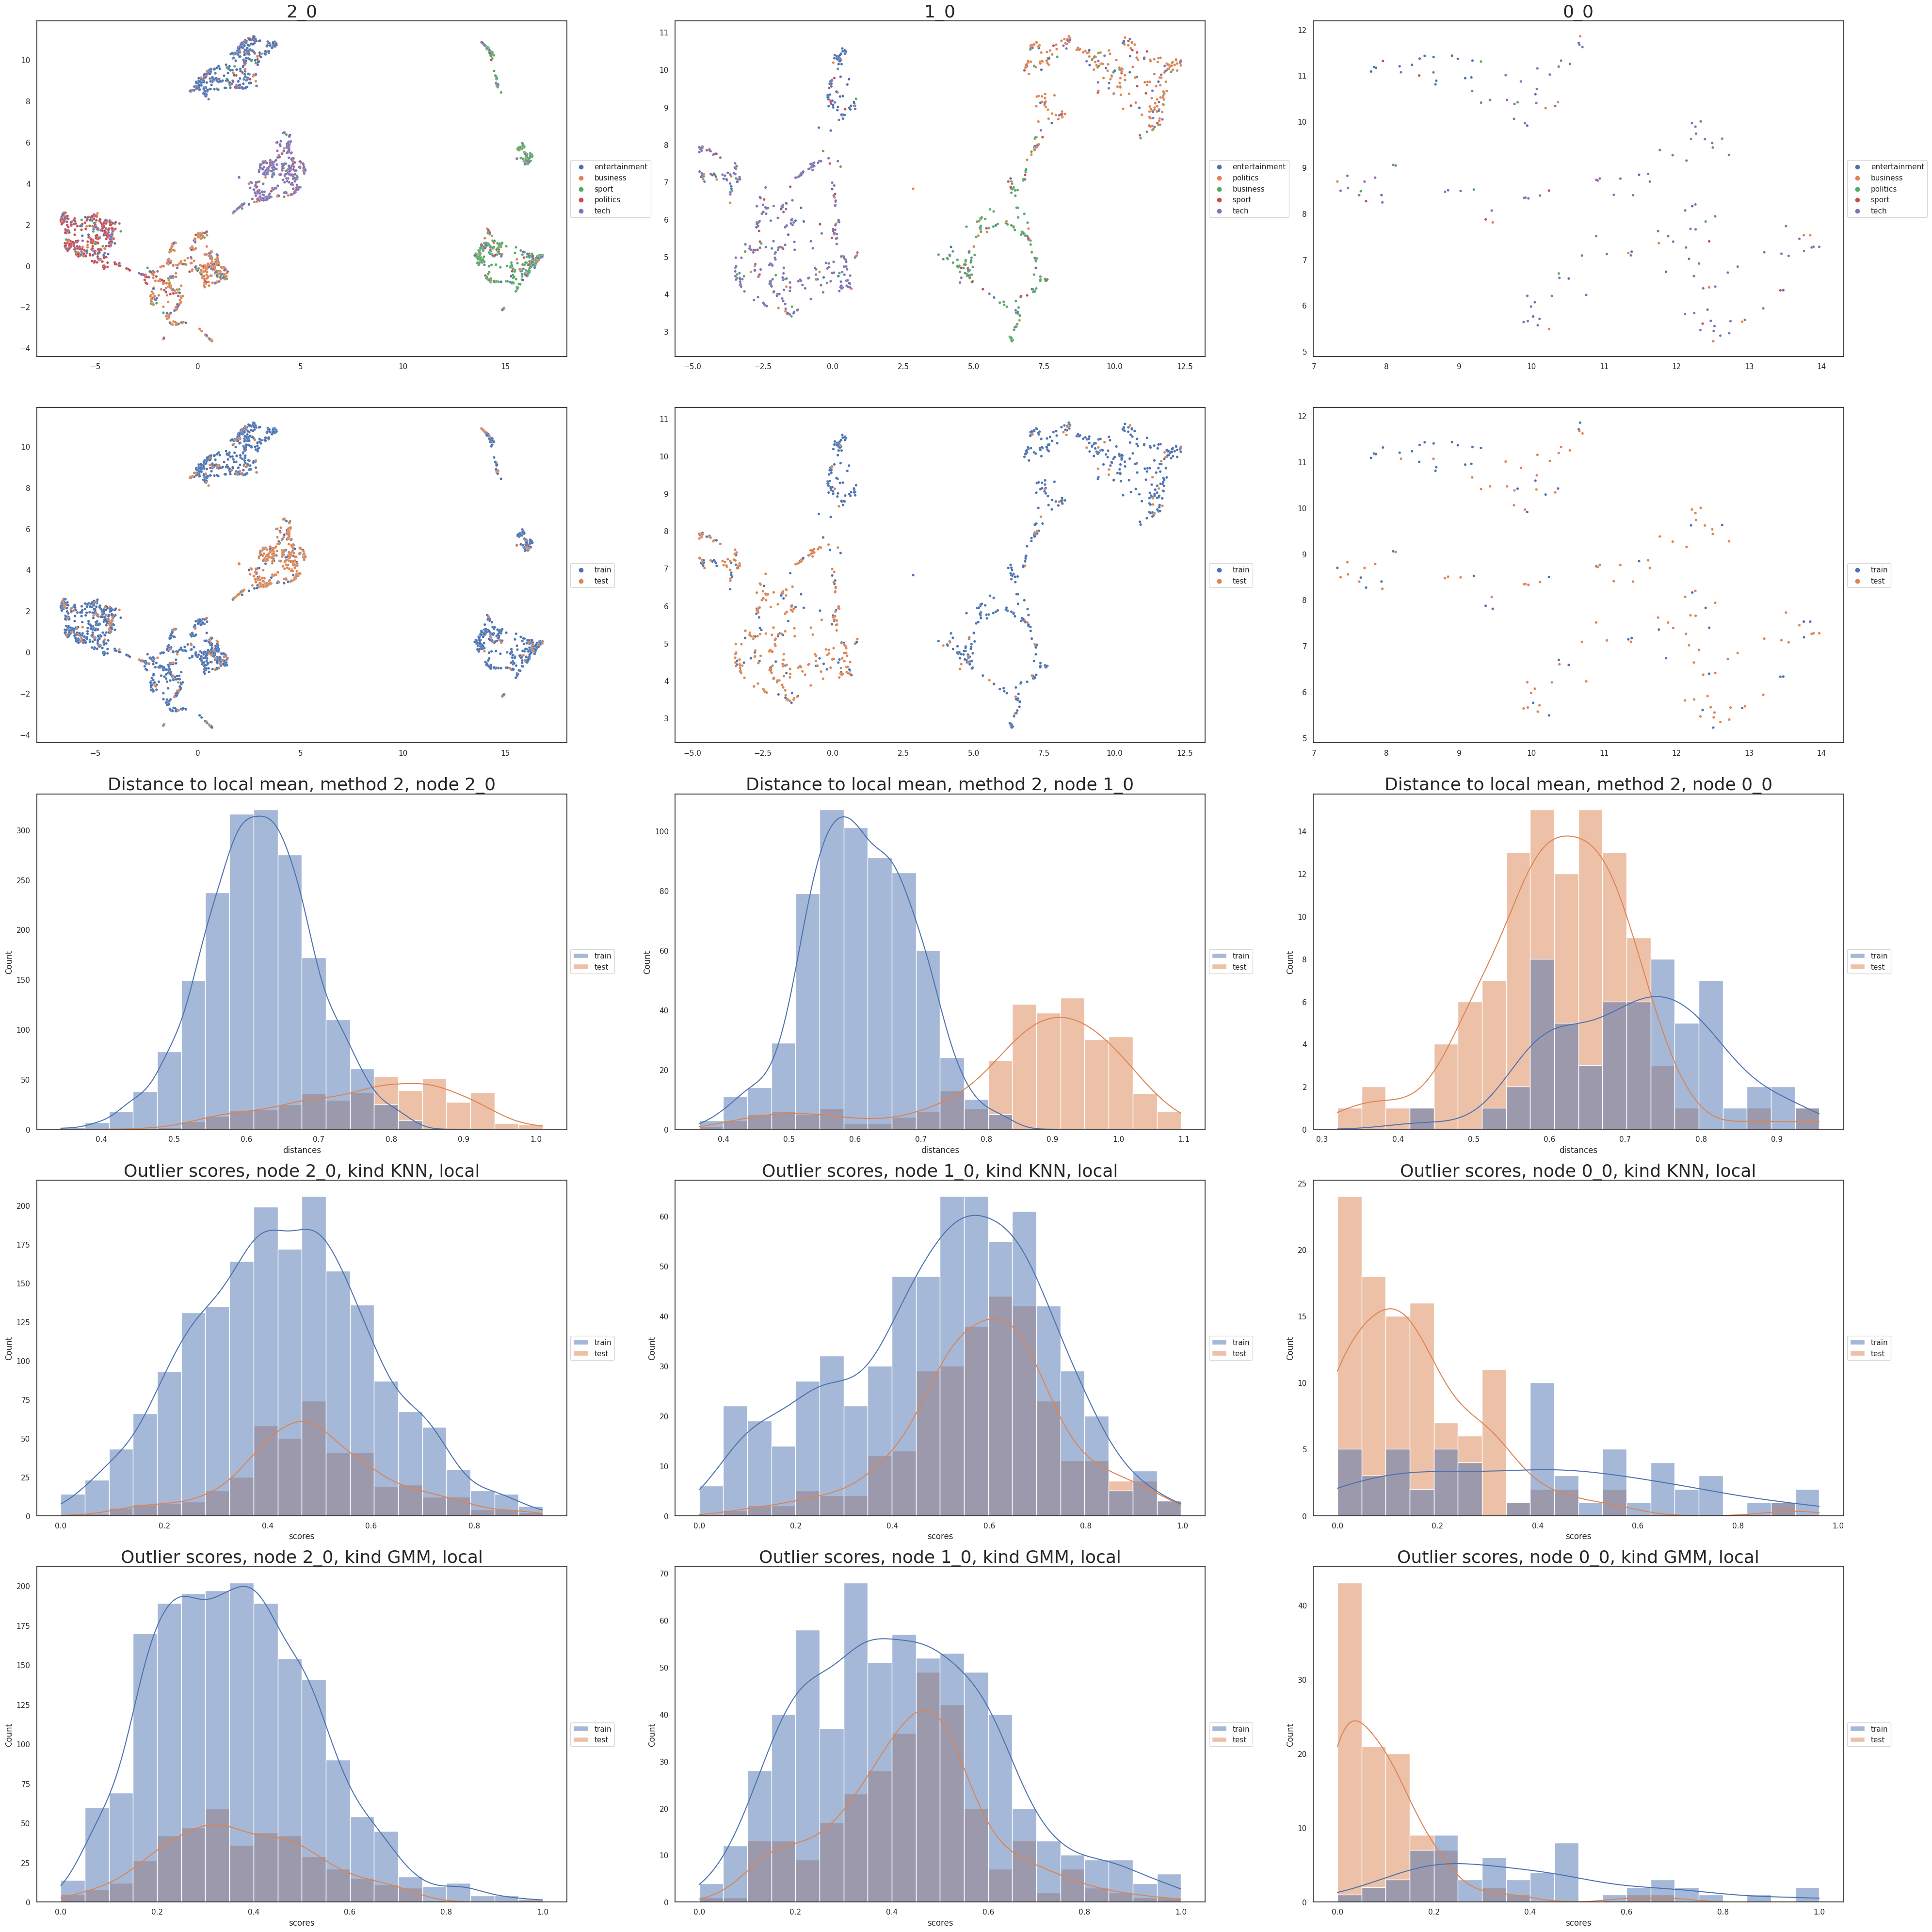

In [9]:
from tqdm import tqdm

def get_distance_m2(node):
    """
    get distance from mean the second method:
    by calculating based on difference
    """
    train = _project_points(node)
    test = _project_points(node, on_train=False)
    # get train and test means
    train_mean = train.mean(axis=0).reshape(1, -1)  # (1 x d)
    test_mean = test.mean(axis=0).reshape(1, -1)  # (1 x d)

    # center train data at 0
    train = pd.DataFrame(train).subtract(train_mean, axis=1)  # (n_points_tr x d) 
    assert all(train.mean(axis=0) < 1e-10)  # check that train data is centered at 0

    # center test data at difference between train and test means
    test = pd.DataFrame(test).subtract(train_mean - test_mean, axis=1)  # (n_points_te x d)

    # get distances from train mean for train, distances from mean for test
    train_dist = np.linalg.norm(train, axis=1)  # (n_points_tr,)
    test_dist = np.linalg.norm(test, axis=1)  # (n_points_te,)
    
    distances_df = pd.concat((pd.Series(train_dist), 
                              pd.Series(test_dist)), 
                             keys=['train', 'test']).reset_index().drop("level_1", axis=1).rename({"level_0": "on", 0: "distances"}, axis=1)
    
    return distances_df

def outlier_scores(node, kind='KNN', *args, **kwargs):
    # setup
    MODELS = {'KNN': KNN, 'GMM': GMM, 'KDE': KDE}
    MODEL = MODELS[kind]
    clf = MODEL(contamination=.1)
    train = _project_points(node)
    test = _project_points(node, on_train=False)
    
    # get scores
    clf.fit(train)
    train_scores = clf.predict_proba(train)[:, 1]
    test_scores = clf.predict_proba(test)[:, 1]

    # turn into df
    df = pd.concat((pd.Series(train_scores),
                    pd.Series(test_scores)),
                    keys=['train', 
                          'test']).reset_index().drop("level_1", 
                                                     axis=1).rename({"level_0": "on", 
                                                                     0: "scores"}, axis=1)

    return df

def get_legend(g):
    legend = g.get_legend()
    handles = legend.legendHandles
    labels = [t.get_text() for t in legend.texts]
    legend.remove()
    g.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
                    
                    
fig, axs = plt.subplots(5, 3, figsize=(40, 40))

# loop through every node in the branch and plot everything
for i, node in tqdm(enumerate(branch)):
    
    # set up data
    ax = axs[0, i]
    node = _get_node(tree[0], node)
    proj_data, node_y = project(node, y_train=Y_train, y_test=Y_test)
    ax.set_title(node.name(), fontsize=26)

    
    # first row: nodes colored by label
    g = sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                    hue=node_y, s=15, linewidth=.15, ax=axs[0, i])
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
    # second row: nodes colored by train/test
    idx_train = _get_idx(node, on_train=True)
    idx_test = _get_idx(node, on_train=False)
    y_train = np.where(Y_train=='tech', 'test', 'train')
    y_test = np.where(Y_test=='tech', 'test', 'train')
    y_train = y_train[idx_train]
    y_test = y_test[idx_test]
    y = np.concatenate((y_train, y_test))
    g = sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                hue=y, s=15, linewidth=.15, ax=axs[1, i])
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
    # third row: distance to local mean (histogram)
    distances_df = get_distance_m2(node)
    g = sns.histplot(data=distances_df, x='distances', hue='on', 
                 ax=axs[2, i], bins=20, kde=True)
    g.set_title(f"Distance to local mean, method 2, node {node.name()}", fontsize=26)
    get_legend(g)
    
    # Fourth row: outlier scores (KNN)
    kind = 'KNN'
    outliers_df = outlier_scores(node, kind=kind)
    g = sns.histplot(data=outliers_df, x='scores', hue='on', 
                 ax=axs[3, i], bins=20, kde=True)
    g.set_title(f"Outlier scores, node {node.name()}, kind {kind}, local", fontsize=26)
    get_legend(g)
    
    # Fifth row: outlier scores (GMM)
    kind = 'GMM'
    outliers_df = outlier_scores(node, kind=kind)
    g = sns.histplot(data=outliers_df, x='scores', hue='on', 
                 ax=axs[4, i], bins=20, kde=True)
    g.set_title(f"Outlier scores, node {node.name()}, kind {kind}, local", fontsize=26)
    get_legend(g)
    

plt.tight_layout()

So, here we see a strange phenomenon: despite the fat that the data are clearly separable, especially in the middle column (which comes from the first set of children after the root), the outlier detection scores have the data overlapping with both GMM and KNN. This is probably why we've been so perplexed here.

## Conclusions

The outlier detection methods are off with the default settings for KNN and GMM: they're not picking up the separation that exists.  
The other conclusion is that, in the root node, the training data isn't uniformly distributed: different labels are clearly distributed differently. So, if we're training on the collection of all training data, we're going to have clusters that surround the test data. So the mean of the training data could be right on top of the testing data.

Below is the description for how KNN and GMM both work. You can see for yourself here: https://pyod.readthedocs.io/en/latest/pyod.models.html

I'm using the default settings in all cases.

```
class pyod.models.knn.KNN(contamination=0.1, n_neighbors=5, method='largest', radius=1.0, algorithm='auto', leaf_size=30, metric='minkowski', p=2, metric_params=None, n_jobs=1, **kwargs)[source]
Bases: BaseDetector

kNN class for outlier detection. For an observation, its distance to its kth nearest neighbor could be viewed as the outlying score. It could be viewed as a way to measure the density. See [BAP02, BRRS00] for details.

Three kNN detectors are supported: largest: use the distance to the kth neighbor as the outlier score mean: use the average of all k neighbors as the outlier score median: use the median of the distance to k neighbors as the outlier score
```

And for GMM:
```
class pyod.models.gmm.GMM(n_components=1, covariance_type='full', tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, init_params='kmeans', weights_init=None, means_init=None, precisions_init=None, random_state=None, warm_start=False, contamination=0.1)[source]
Bases: BaseDetector

Wrapper of scikit-learn Gaussian Mixture Model with more functionalities. Unsupervised Outlier Detection.
```

# Try with d=100

Let's see what happens when we train in 100 dimensions instead (and then we'll do 600 dimensions in the future)

In [10]:
gmra100, tree100, root100 = train_gmra(d=100, x_train=X_train, x_test=X_test, gmra_kwargs=gmra_kwargs)

dict_keys([2, 1, 0, -1, -2147483648])
gmra with d=100 saved


3it [00:16,  5.46s/it]


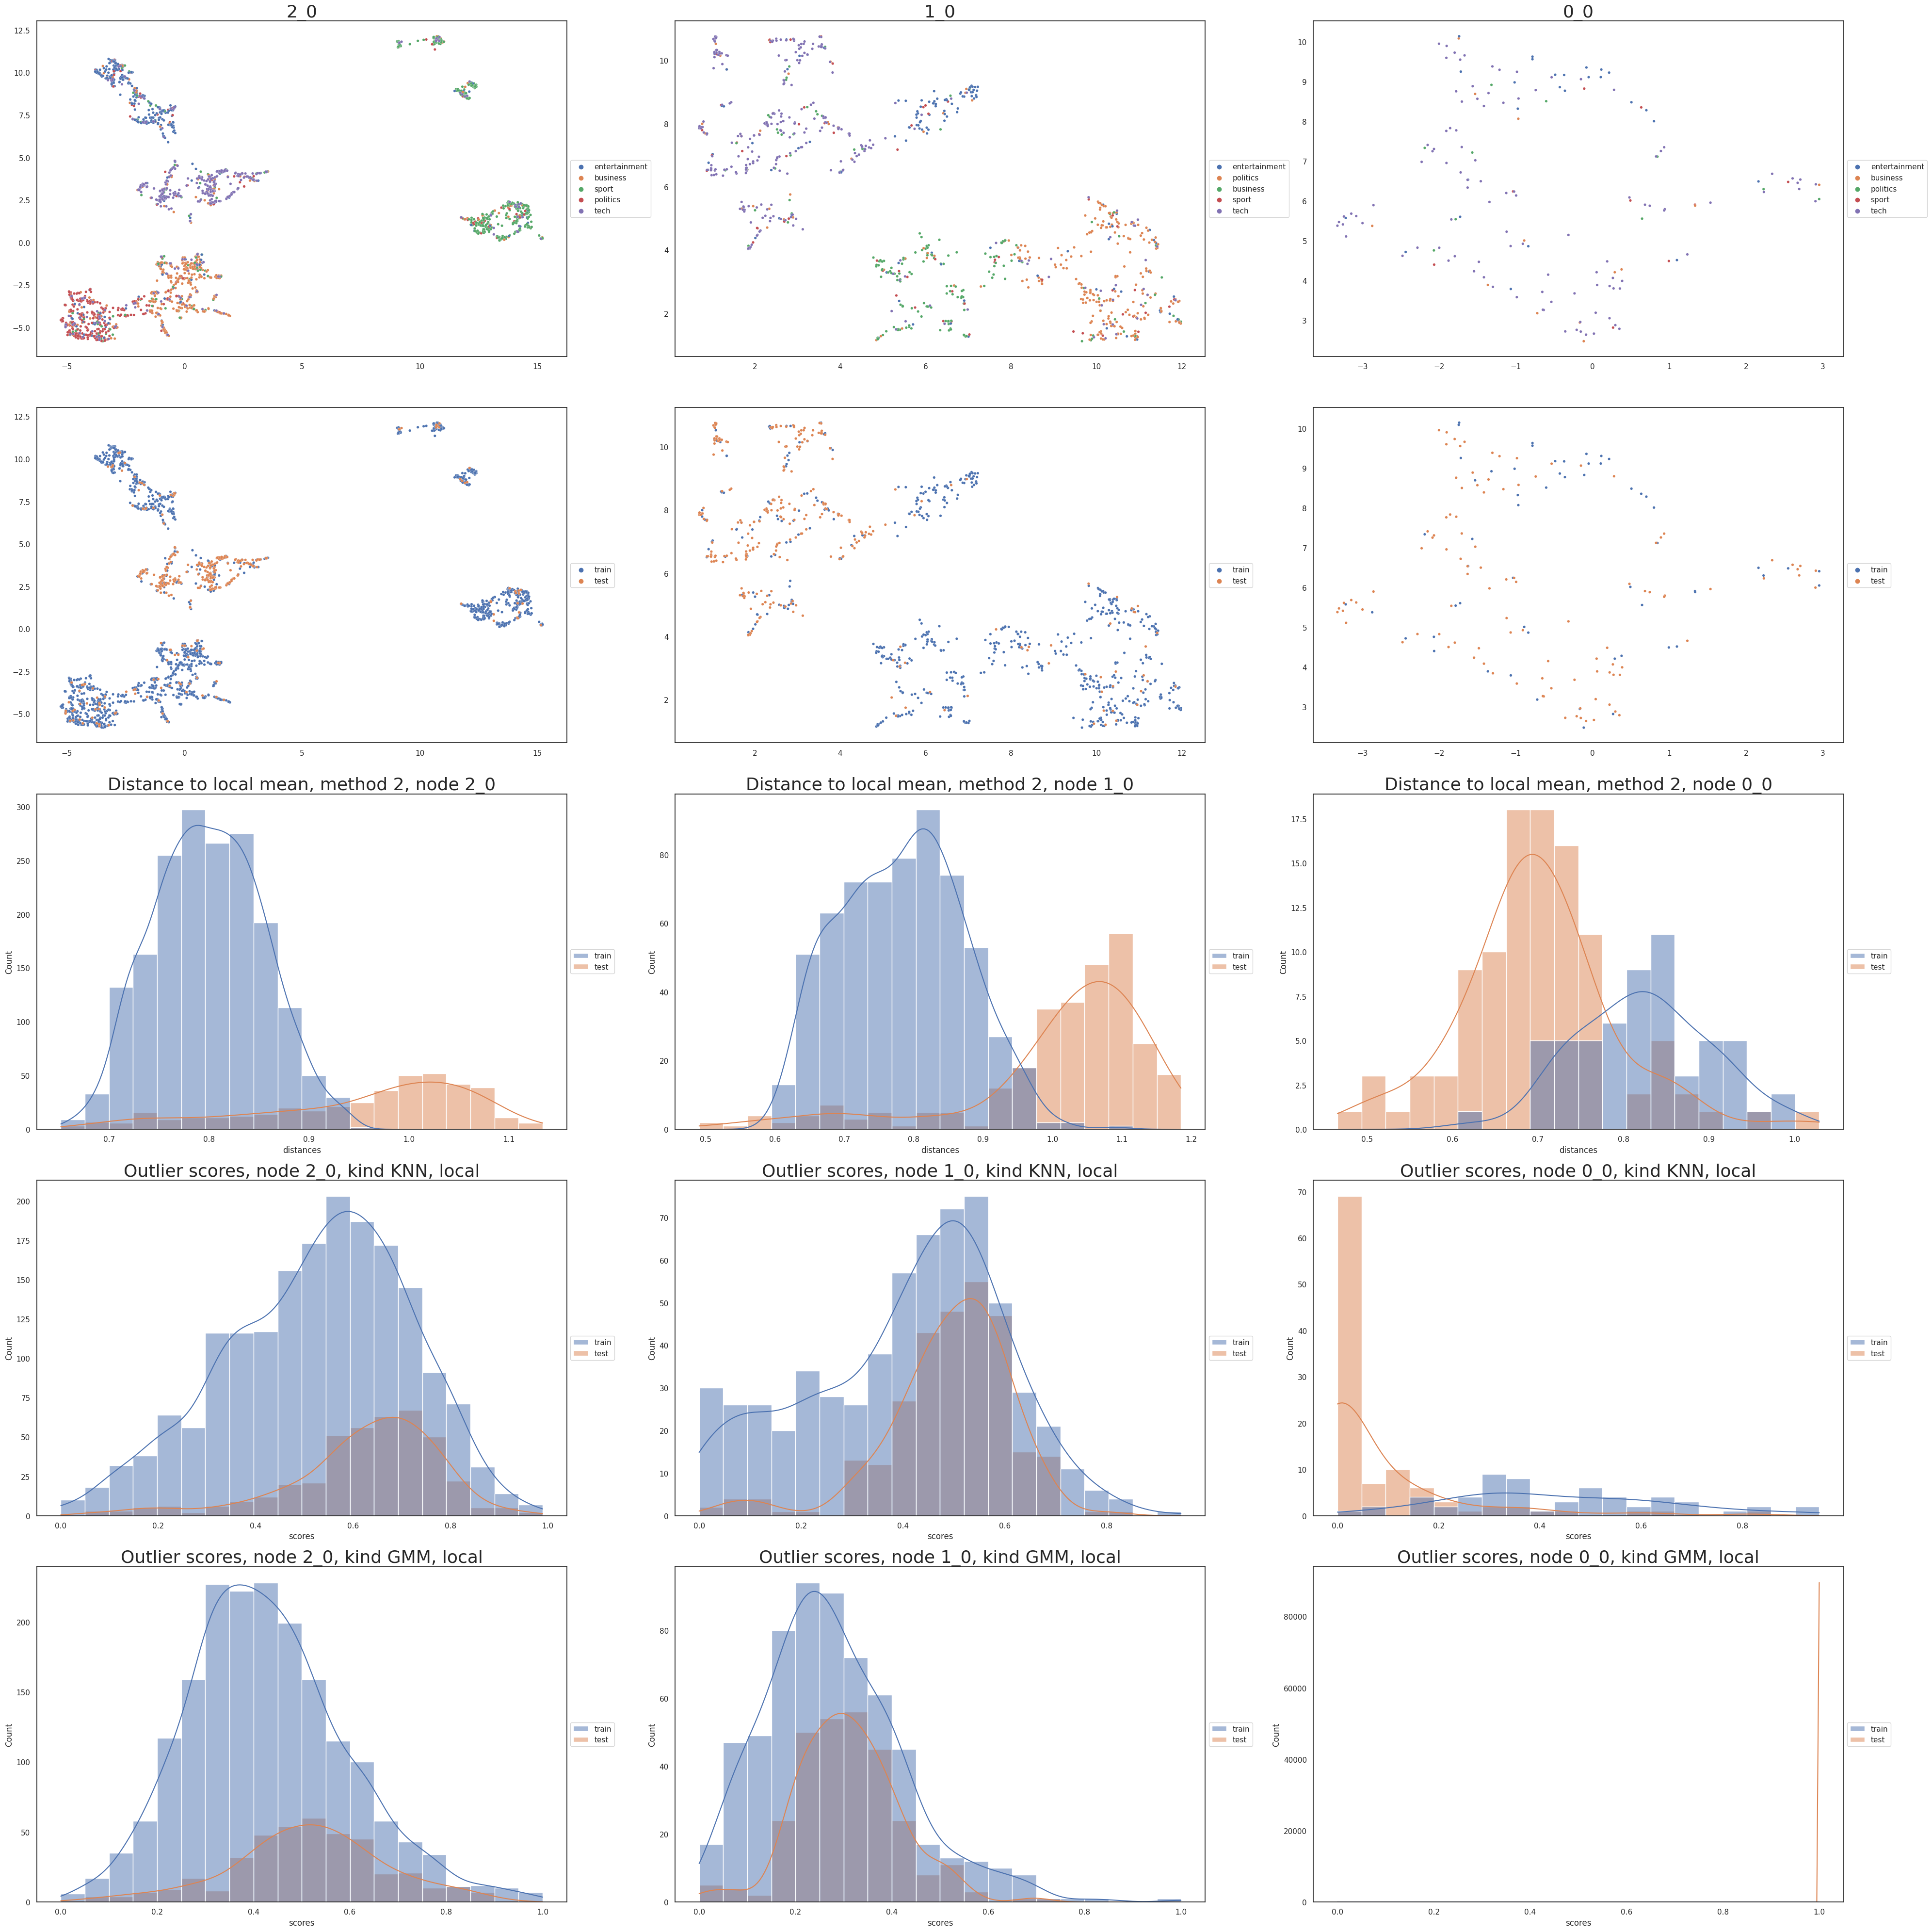

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(40, 40))

# loop through every node in the branch and plot everything
for i, node in tqdm(enumerate(branch)):
    
    # set up data
    ax = axs[0, i]
    node = _get_node(tree100[0], node)
    proj_data, node_y = project(node, y_train=Y_train, y_test=Y_test)
    ax.set_title(node.name(), fontsize=26)

    
    # first row: nodes colored by label
    g = sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                    hue=node_y, s=15, linewidth=.15, ax=axs[0, i])
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
    # second row: nodes colored by train/test
    idx_train = _get_idx(node, on_train=True)
    idx_test = _get_idx(node, on_train=False)
    y_train = np.where(Y_train=='tech', 'test', 'train')
    y_test = np.where(Y_test=='tech', 'test', 'train')
    y_train = y_train[idx_train]
    y_test = y_test[idx_test]
    y = np.concatenate((y_train, y_test))
    g = sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                hue=y, s=15, linewidth=.15, ax=axs[1, i])
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
    # third row: distance to local mean (histogram)
    distances_df = get_distance_m2(node)
    g = sns.histplot(data=distances_df, x='distances', hue='on', 
                 ax=axs[2, i], bins=20, kde=True)
    g.set_title(f"Distance to local mean, method 2, node {node.name()}", fontsize=26)
    get_legend(g)
    
    # Fourth row: outlier scores (KNN)
    kind = 'KNN'
    outliers_df = outlier_scores(node, kind=kind)
    g = sns.histplot(data=outliers_df, x='scores', hue='on', 
                 ax=axs[3, i], bins=20, kde=True)
    g.set_title(f"Outlier scores, node {node.name()}, kind {kind}, local", fontsize=26)
    get_legend(g)
    
    # Fifth row: outlier scores (GMM)
    kind = 'GMM'
    outliers_df = outlier_scores(node, kind=kind)
    g = sns.histplot(data=outliers_df, x='scores', hue='on', 
                 ax=axs[4, i], bins=20, kde=True)
    g.set_title(f"Outlier scores, node {node.name()}, kind {kind}, local", fontsize=26)
    get_legend(g)
    

plt.tight_layout()

So, we see the same phenomenon here. 

## Try with d=600

And the same in 600 dimensions.

dict_keys([2, 1, 0, -1, -2147483648])
gmra with d=600 saved


3it [00:20,  6.95s/it]


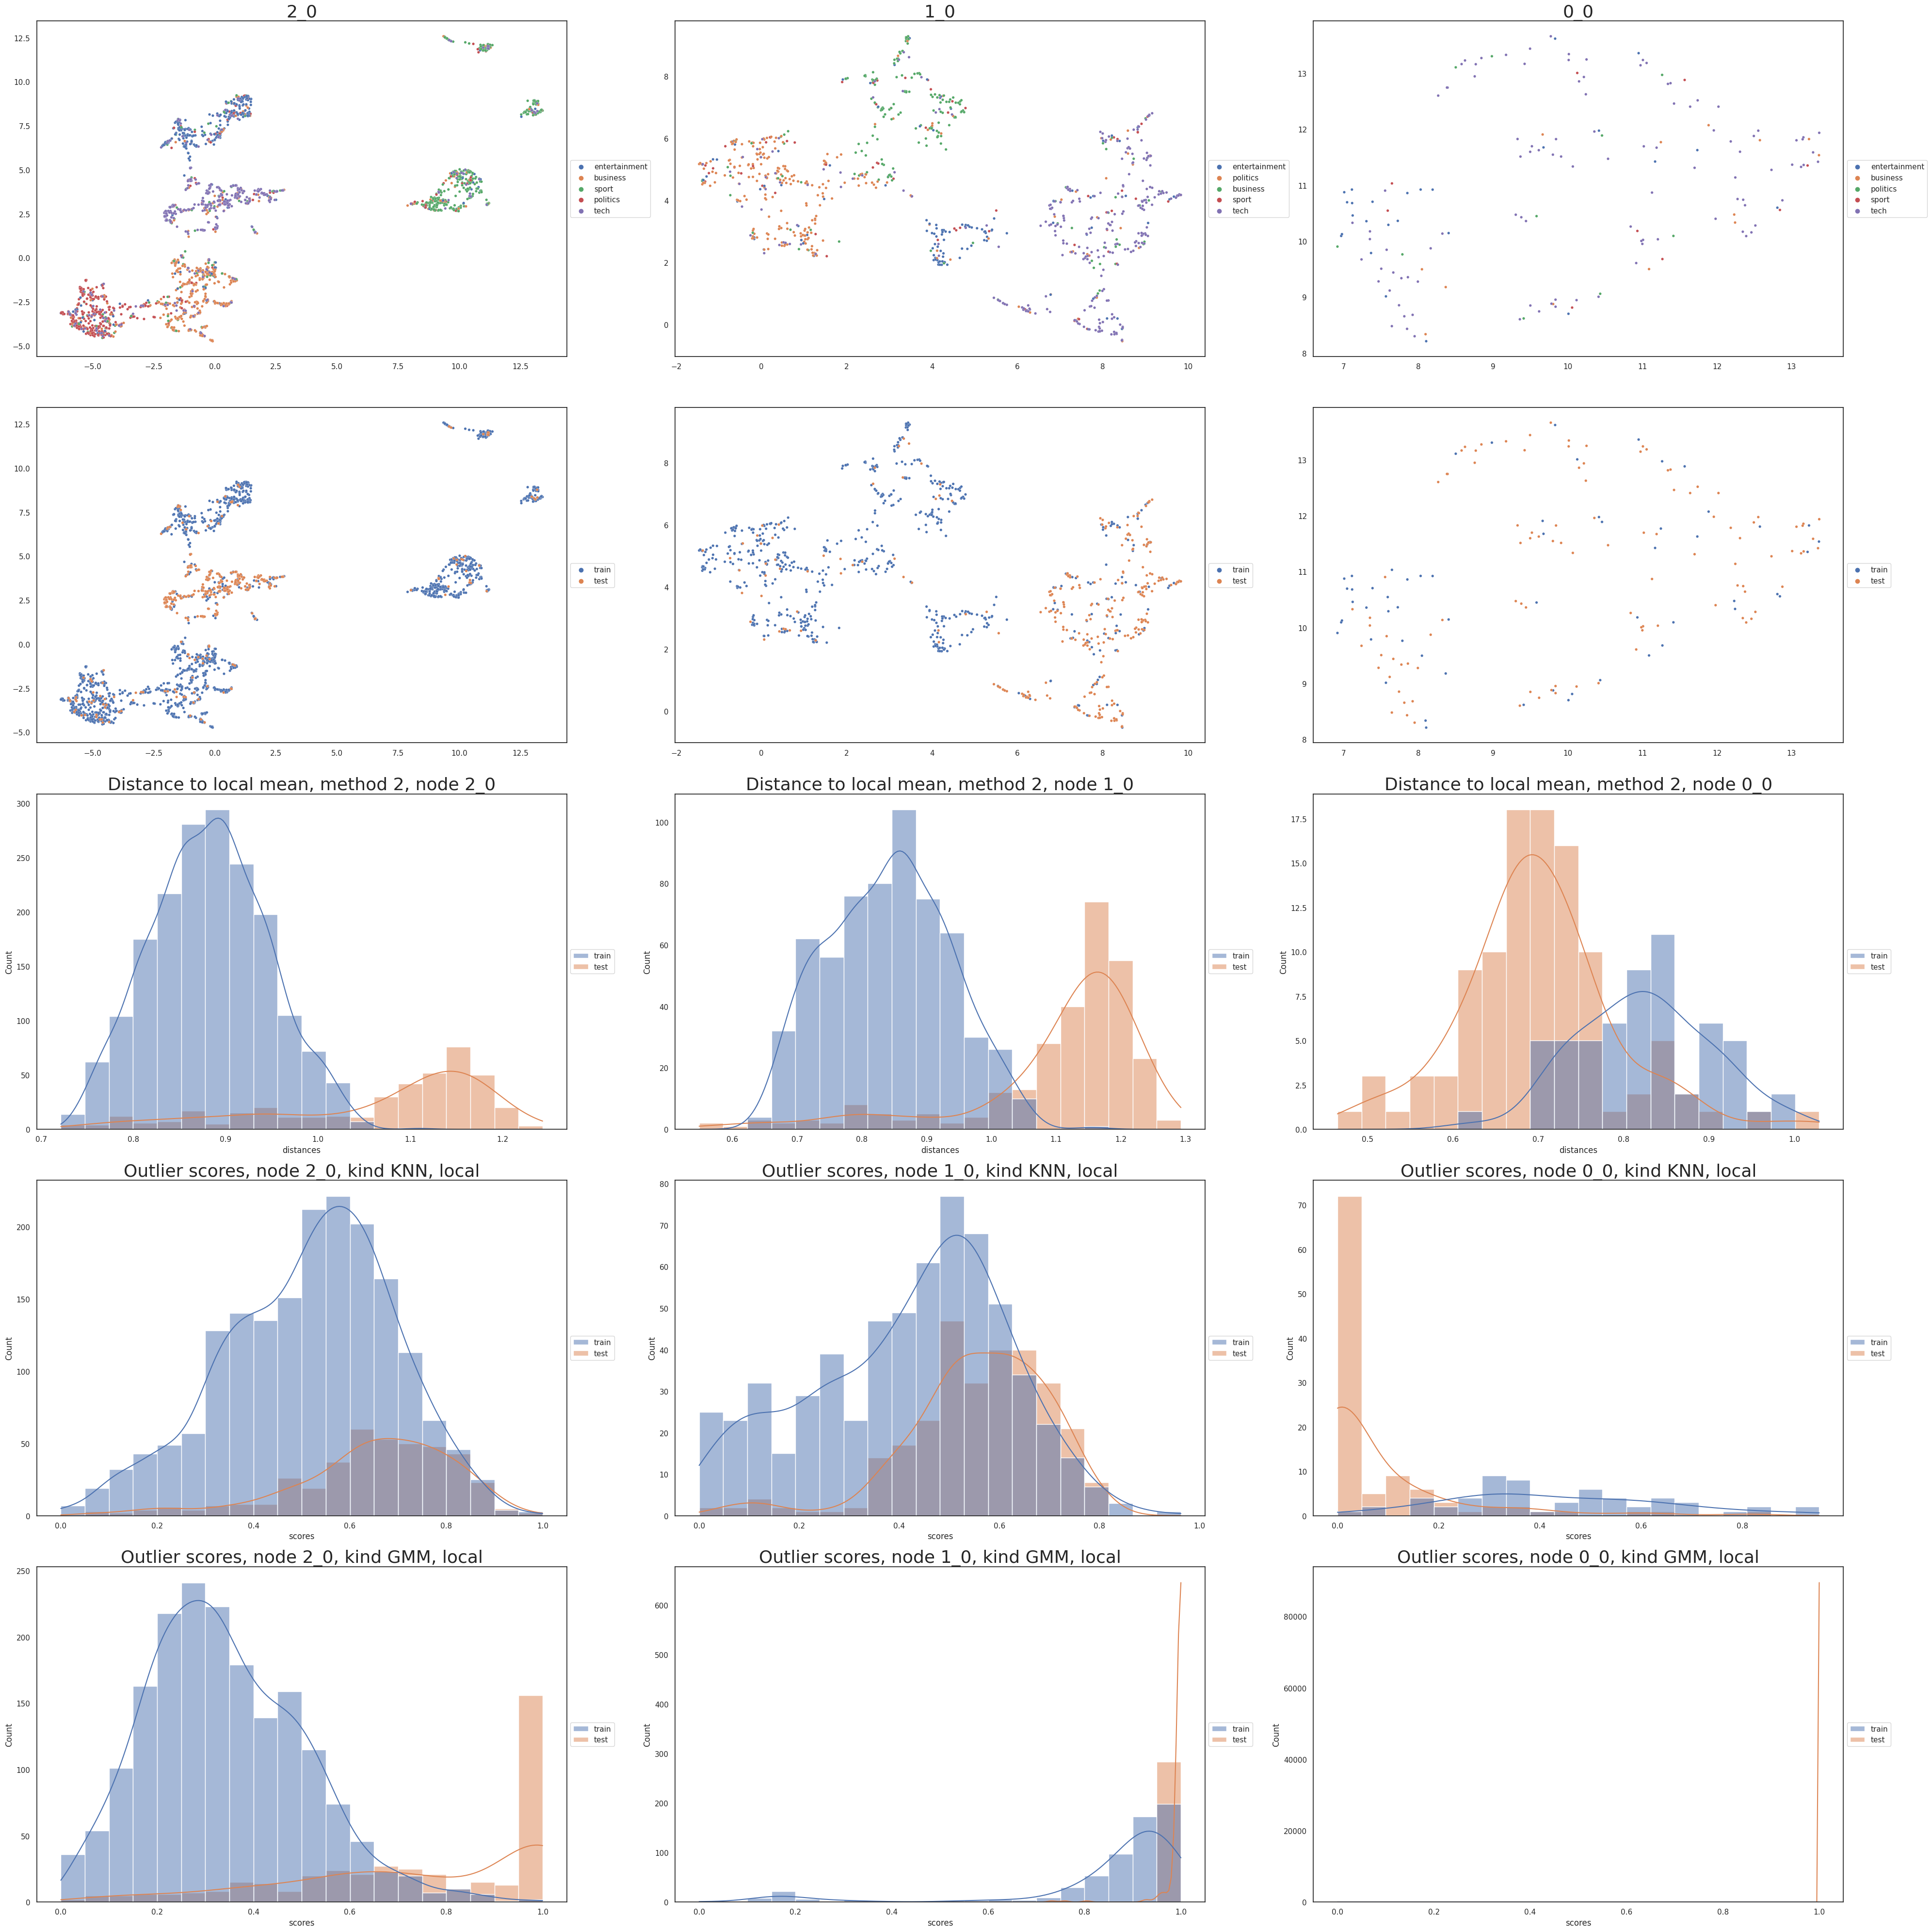

In [12]:
gmra600, tree600, root600 = train_gmra(d=600, x_train=X_train, x_test=X_test, gmra_kwargs=gmra_kwargs)

fig, axs = plt.subplots(5, 3, figsize=(40, 40))

# loop through every node in the branch and plot everything
for i, node in tqdm(enumerate(branch)):
    
    # set up data
    ax = axs[0, i]
    node = _get_node(tree600[0], node)
    proj_data, node_y = project(node, y_train=Y_train, y_test=Y_test)
    ax.set_title(node.name(), fontsize=26)

    
    # first row: nodes colored by label
    g = sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                    hue=node_y, s=15, linewidth=.15, ax=axs[0, i])
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
    # second row: nodes colored by train/test
    idx_train = _get_idx(node, on_train=True)
    idx_test = _get_idx(node, on_train=False)
    y_train = np.where(Y_train=='tech', 'test', 'train')
    y_test = np.where(Y_test=='tech', 'test', 'train')
    y_train = y_train[idx_train]
    y_test = y_test[idx_test]
    y = np.concatenate((y_train, y_test))
    g = sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], 
                hue=y, s=15, linewidth=.15, ax=axs[1, i])
    g.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), facecolor='white')
    
    # third row: distance to local mean (histogram)
    distances_df = get_distance_m2(node)
    g = sns.histplot(data=distances_df, x='distances', hue='on', 
                 ax=axs[2, i], bins=20, kde=True)
    g.set_title(f"Distance to local mean, method 2, node {node.name()}", fontsize=26)
    get_legend(g)
    
    # Fourth row: outlier scores (KNN)
    kind = 'KNN'
    outliers_df = outlier_scores(node, kind=kind)
    g = sns.histplot(data=outliers_df, x='scores', hue='on', 
                 ax=axs[3, i], bins=20, kde=True)
    g.set_title(f"Outlier scores, node {node.name()}, kind {kind}, local", fontsize=26)
    get_legend(g)
    
    # Fifth row: outlier scores (GMM)
    kind = 'GMM'
    outliers_df = outlier_scores(node, kind=kind)
    g = sns.histplot(data=outliers_df, x='scores', hue='on', 
                 ax=axs[4, i], bins=20, kde=True)
    g.set_title(f"Outlier scores, node {node.name()}, kind {kind}, local", fontsize=26)
    get_legend(g)
    

plt.tight_layout()